Gated Recurrent Units (GRUs) excel at review classification tasks like identifying positive or negative sentiment. They effectively exploit the sequential nature of text, remembering previous words' sentiment to understand the overall context. Like a master interpreter, GRUs analyze each word, filtering irrelevant information and retaining key emotional cues. They learn from labeled reviews, associating specific words and phrases with positive or negative connotations. Armed with this understanding, GRUs process new reviews, their internal memory capturing the evolving sentiment and ultimately predicting the overall positive or negative classification with impressive accuracy. This makes them valuable tools for analyzing customer feedback, gauging public opinion, and even building chatbots that understand emotional nuances.

In [ ]:
import gc
import re
import operator

import numpy as np
import pandas as pd
import seaborn as sns

from gensim.models import KeyedVectors

from sklearn import model_selection

from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.layers import Embedding, Input, Dense, concatenate, Bidirectional, SpatialDropout1D, Conv1D, GlobalAveragePooling1D, GlobalMaxPooling1D
from tensorflow.keras.optimizers import RMSprop
from tensorflow.keras.optimizers import Adam
from keras.models import Model
from keras.callbacks import EarlyStopping

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!ls /content/drive/MyDrive/RNN1

 48k_augment.csv  'Copy of 48k_augment.csv'   GoogleNews.bin   test.csv   train.csv


In [ ]:
df_train = pd.read_csv("/content/drive/MyDrive/RNN1/train.csv")
df_test = pd.read_csv("/content/drive/MyDrive/RNN1/test.csv")

df_train.shape


(1804874, 45)

In [ ]:
df_test.head()

,id,comment_text
0,7097320,[ Integrity means that you pay your debts.]\n\...
1,7097321,This is malfeasance by the Administrator and t...
2,7097322,@Rmiller101 - Spoken like a true elitist. But ...
3,7097323,"Paul: Thank you for your kind words. I do, in..."
4,7097324,Sorry you missed high school. Eisenhower sent ...


In [ ]:
df = pd.concat([df_train[['id','comment_text']], df_test])
del(df_train, df_test)

## Embeddings:
### To start we'll just take the Google News word vectors file to use as embeddings. Later, we'll hopefully combine multiple embeddings.


In [ ]:
from gensim.models import KeyedVectors

# Path to the downloaded Google News word vectors file
google_news_file = "/content/drive/MyDrive/RNN1/GoogleNews.bin"

try:
    # Load Google News word vectors
    print(f'Loading Google News word vectors from {google_news_file}...')
    embeddings_index = KeyedVectors.load_word2vec_format(google_news_file, binary=True)

    # Example usage: Get the word vector for a specific word if it exists in the vocabulary
    word = 'king'
    if word in embeddings_index:
        word_vector = embeddings_index[word]
        print(f'Word vector for "{word}":\n{word_vector}')
    else:
        print(f'Word "{word}" not found in the vocabulary.')
except ValueError as e:
    print(f"Error: {e}")


Loading Google News word vectors from /content/drive/MyDrive/RNN1/GoogleNews.bin...
Word vector for "king":
[ 1.25976562e-01  2.97851562e-02  8.60595703e-03  1.39648438e-01
 -2.56347656e-02 -3.61328125e-02  1.11816406e-01 -1.98242188e-01
  5.12695312e-02  3.63281250e-01 -2.42187500e-01 -3.02734375e-01
 -1.77734375e-01 -2.49023438e-02 -1.67968750e-01 -1.69921875e-01
  3.46679688e-02  5.21850586e-03  4.63867188e-02  1.28906250e-01
  1.36718750e-01  1.12792969e-01  5.95703125e-02  1.36718750e-01
  1.01074219e-01 -1.76757812e-01 -2.51953125e-01  5.98144531e-02
  3.41796875e-01 -3.11279297e-02  1.04492188e-01  6.17675781e-02
  1.24511719e-01  4.00390625e-01 -3.22265625e-01  8.39843750e-02
  3.90625000e-02  5.85937500e-03  7.03125000e-02  1.72851562e-01
  1.38671875e-01 -2.31445312e-01  2.83203125e-01  1.42578125e-01
  3.41796875e-01 -2.39257812e-02 -1.09863281e-01  3.32031250e-02
 -5.46875000e-02  1.53198242e-02 -1.62109375e-01  1.58203125e-01
 -2.59765625e-01  2.01416016e-02 -1.63085938e-0

Preprocessing Text
Like most NLP tasks, we begin by leveraging pre-trained word embeddings. These assign numerical values to words, allowing us to feed them into machine learning models. However, mapping words to these embeddings isn't always smooth sailing. The data often requires some cleaning up first.

In [ ]:
def build_vocab(texts):
    sentences = texts.apply(lambda x: x.split()).values
    vocab = {}
    for sentence in sentences:
        for word in sentence:
            try:
                vocab[word] += 1
            except KeyError:
                vocab[word] = 1
    return vocab

In [ ]:
def check_coverage(vocab, embeddings_index):
    known_words = {}
    unknown_words = {}
    nb_known_words = 0
    nb_unknown_words = 0
    for word in vocab.keys():
        try:
            known_words[word] = embeddings_index[word]
            nb_known_words += vocab[word]
        except:
            unknown_words[word] = vocab[word]
            nb_unknown_words += vocab[word]
            pass

    print('Found embeddings for {:.3%} of vocab'.format(len(known_words) / len(vocab)))
    print('Found embeddings for  {:.3%} of all text'.format(nb_known_words / (nb_known_words + nb_unknown_words)))
    unknown_words = sorted(unknown_words.items(), key=operator.itemgetter(1))[::-1]

    return unknown_words

We will lower() all words.

In [ ]:
df['comment_text'] = df['comment_text'].apply(lambda x: x.lower())

In [ ]:
vocab = build_vocab(df['comment_text'])
oov = check_coverage(vocab, embeddings_index)
oov[:10]

Found embeddings for 6.006% of vocab
Found embeddings for  75.685% of all text


[('to', 2780660),
 ('and', 2351962),
 ('of', 2152705),
 ('a', 2053557),
 ('-', 187641),
 ("i'm", 87857),
 ('.', 75813),
 ('mr.', 32450),
 ('it,', 31439),
 ('trudeau', 29978)]

In [ ]:
contraction_mapping = {"ain't": "is not", "aren't": "are not","can't": "cannot", "'cause": "because", "could've": "could have", "couldn't": "could not",
                       "didn't": "did not",  "doesn't": "does not", "don't": "do not", "hadn't": "had not", "hasn't": "has not", "haven't": "have not",
                       "he'd": "he would","he'll": "he will", "he's": "he is", "how'd": "how did", "how'd'y": "how do you", "how'll": "how will",
                       "how's": "how is",  "I'd": "I would", "I'd've": "I would have", "I'll": "I will", "I'll've": "I will have","I'm": "I am",
                       "I've": "I have", "i'd": "i would", "i'd've": "i would have", "i'll": "i will",  "i'll've": "i will have","i'm": "i am",
                       "i've": "i have", "isn't": "is not", "it'd": "it would", "it'd've": "it would have", "it'll": "it will", "it'll've": "it will have",
                       "it's": "it is", "let's": "let us", "ma'am": "madam", "mayn't": "may not", "might've": "might have","mightn't": "might not",
                       "mightn't've": "might not have", "must've": "must have", "mustn't": "must not", "mustn't've": "must not have", "needn't": "need not",
                       "needn't've": "need not have","o'clock": "of the clock", "oughtn't": "ought not", "oughtn't've": "ought not have", "shan't": "shall not"
                       , "sha'n't": "shall not", "shan't've": "shall not have", "she'd": "she would", "she'd've": "she would have", "she'll": "she will", "she'll've"
                       : "she will have", "she's": "she is", "should've": "should have", "shouldn't": "should not", "shouldn't've": "should not have", "so've": "so have"
                       ,"so's": "so as", "this's": "this is","that'd": "that would", "that'd've": "that would have", "that's": "that is", "there'd": "there would", "there'd've": "there would have",
                       "there's": "there is", "here's": "here is","they'd": "they would", "they'd've": "they would have", "they'll": "they will", "they'll've": "they will have",
                       "they're": "they are", "they've": "they have", "to've": "to have", "wasn't": "was not", "we'd": "we would", "we'd've": "we would have", "we'll": "we will", "we'll've": "we will have",
                       "we're": "we are", "we've": "we have", "weren't": "were not", "what'll": "what will", "what'll've": "what will have", "what're": "what are",
                       "what's": "what is", "what've": "what have", "when's": "when is", "when've": "when have", "where'd": "where did", "where's": "where is", "where've": "where have",
                       "who'll": "who will", "who'll've": "who will have", "who's": "who is", "who've": "who have", "why's": "why is", "why've": "why have", "will've": "will have",
                       "won't": "will not", "won't've": "will not have", "would've": "would have", "wouldn't": "would not", "wouldn't've": "would not have", "y'all": "you all",
                       "y'all'd": "you all would","y'all'd've": "you all would have","y'all're": "you all are","y'all've": "you all have","you'd": "you would", "you'd've": "you would have", "you'll": "you will", "you'll've": "you will have", "you're": "you are", "you've": "you have" }

In [ ]:
del(vocab,oov)

In [ ]:
def known_contractions(embed):
    known = []
    for contract in contraction_mapping:
        if contract in embed:
            known.append(contract)
    return known

In [ ]:
print(known_contractions(embeddings_index))

["ain't", "aren't", "can't", "could've", "couldn't", "didn't", "doesn't", "don't", "hadn't", "hasn't", "haven't", "he'd", "he'll", "he's", "how'd", "how's", "I'd", "I'd've", "I'll", "I'm", "I've", "isn't", "it'd", "it'll", "it's", "let's", "ma'am", "must've", "o'clock", "oughtn't", "she'd", "she'll", "she's", "should've", "shouldn't", "that's", "there's", "here's", "they'd", "they'll", "they're", "they've", "wasn't", "we'd", "we'll", "we're", "we've", "weren't", "what're", "what's", "what've", "where'd", "where's", "who'll", "who's", "who've", "won't", "would've", "wouldn't", "wouldn't've", "y'all", "you'd", "you'll", "you're", "you've"]


In [ ]:
def clean_contractions(text, mapping):
    specials = ["’", "‘", "´", "`"]
    for s in specials:
        text = text.replace(s, "'")
    text = ' '.join([mapping[t] if t in mapping else t for t in text.split(" ")])
    return text

In [ ]:
df['comment_text'] = df['comment_text'].apply(lambda x: clean_contractions(x, contraction_mapping))

In [ ]:
vocab = build_vocab(df['comment_text'])
oov = check_coverage(vocab, embeddings_index)
oov[:10]

Found embeddings for 6.041% of vocab
Found embeddings for  76.186% of all text


[('to', 2780661),
 ('and', 2351962),
 ('of', 2152801),
 ('a', 2053557),
 ('-', 187641),
 ('.', 75813),
 ('mr.', 32450),
 ('it,', 31439),
 ('trudeau', 29978),
 ('that.', 29816)]

Looks like punctuation is the next issue here, so let's fix it.

In [ ]:
del(vocab,oov)

In [ ]:
punct = "/-'?!.,#$%\'()*+-/:;<=>@[\\]^_`{|}~" + '""“”’' + '∞θ÷α•à−β∅³π‘₹´°£€\×™√²—–&'

In [ ]:
def unknown_punct(embed, punct):
    unknown = ''
    for p in punct:
        if p not in embed:
            unknown += p
            unknown += ' '
    return unknown

In [ ]:
print(unknown_punct(embeddings_index, punct))

/ - ' ? ! . , ' ( ) - / : ; < [ \ ] { | } " " “ ” ’ − ∅ ‘ ₹ ´ \ — – 


In [ ]:
punct_mapping = {"_":" ", "`":" "}

In [ ]:
def clean_special_chars(text, punct, mapping):
    for p in mapping:
        text = text.replace(p, mapping[p])
    for p in punct:
        text = text.replace(p, f' {p} ')
    return text

In [ ]:
df['comment_text'] = df['comment_text'].apply(lambda x: clean_special_chars(x, punct, punct_mapping))

In [ ]:
vocab = build_vocab(df['comment_text'])
oov = check_coverage(vocab, embeddings_index)

Found embeddings for 29.970% of vocab
Found embeddings for  75.748% of all text


In [ ]:
oov[:50]

[('.', 7327088),
 (',', 3777005),
 ('to', 2812238),
 ('and', 2420791),
 ('of', 2172310),
 ('a', 2085743),
 ('"', 1264743),
 ('-', 1198866),
 ('?', 829797),
 ("'", 752615),
 ('/', 460144),
 ('!', 428313),
 (')', 323492),
 ('(', 297227),
 (':', 243990),
 (';', 80666),
 ('“', 42906),
 ('”', 42612),
 ('trudeau', 41289),
 ('000', 40402),
 ('10', 35146),
 ('20', 24388),
 ('100', 22693),
 ('50', 20998),
 ('30', 18938),
 ('2016', 16396),
 ('2017', 16354),
 ('15', 15353),
 ('alaskans', 13016),
 ('12', 12981),
 ('[', 12670),
 (']', 12610),
 ('40', 12341),
 ('25', 11560),
 ('11', 11451),
 ('—', 11018),
 ('60', 9360),
 ('2015', 9082),
 ('comey', 8703),
 ('18', 7699),
 ('–', 7628),
 ('500', 7470),
 ('90', 7450),
 ('70', 7354),
 ('80', 7302),
 ('16', 7299),
 ('alaskan', 7123),
 ('24', 6390),
 ('13', 6283),
 ('khadr', 6255)]

Many words lack pre-trained embeddings. While misspelling correction could help, it's a minor improvement we can address later when optimizing the model.

In [ ]:
del(vocab,oov)

Swears
Let's replace any swear words we don't have an embedding for with something we do ;)

In [ ]:
swear_words = [
    ' 4r5e ',
    ' 5h1t ',
    ' 5hit ',
    ' a55 ',
    ' anal ',
    ' anus ',
    ' ar5e ',
    ' arrse ',
    ' arse ',
    ' ass ',
    ' ass-fucker ',
    ' asses ',
    ' assfucker ',
    ' assfukka ',
    ' asshole ',
    ' assholes ',
    ' asswhole ',
    ' a_s_s ',
    ' b!tch ',
    ' b00bs ',
    ' b17ch ',
    ' b1tch ',
    ' ballbag ',
    ' balls ',
    ' ballsack ',
    ' bastard ',
    ' beastial ',
    ' beastiality ',
    ' bellend ',
    ' bestial ',
    ' bestiality ',
    ' biatch ',
    ' bitch ',
    ' bitcher ',
    ' bitchers ',
    ' bitches ',
    ' bitchin ',
    ' bitching ',
    ' bloody ',
    ' blow job ',
    ' blowjob ',
    ' blowjobs ',
    ' boiolas ',
    ' bollock ',
    ' bollok ',
    ' boner ',
    ' boob ',
    ' boobs ',
    ' booobs ',
    ' boooobs ',
    ' booooobs ',
    ' booooooobs ',
    ' breasts ',
    ' buceta ',
    ' bugger ',
    ' bum ',
    ' bunny fucker ',
    ' butt ',
    ' butthole ',
    ' buttmuch ',
    ' buttplug ',
    ' c0ck ',
    ' c0cksucker ',
    ' carpet muncher ',
    ' cawk ',
    ' chink ',
    ' cipa ',
    ' cl1t ',
    ' clit ',
    ' clitoris ',
    ' clits ',
    ' cnut ',
    ' cock ',
    ' cock-sucker ',
    ' cockface ',
    ' cockhead ',
    ' cockmunch ',
    ' cockmuncher ',
    ' cocks ',
    ' cocksuck ',
    ' cocksucked ',
    ' cocksucker ',
    ' cocksucking ',
    ' cocksucks ',
    ' cocksuka ',
    ' cocksukka ',
    ' cok ',
    ' cokmuncher ',
    ' coksucka ',
    ' coon ',
    ' cox ',
    ' crap ',
    ' cum ',
    ' cummer ',
    ' cumming ',
    ' cums ',
    ' cumshot ',
    ' cunilingus ',
    ' cunillingus ',
    ' cunnilingus ',
    ' cunt ',
    ' cuntlick ',
    ' cuntlicker ',
    ' cuntlicking ',
    ' cunts ',
    ' cyalis ',
    ' cyberfuc ',
    ' cyberfuck ',
    ' cyberfucked ',
    ' cyberfucker ',
    ' cyberfuckers ',
    ' cyberfucking ',
    ' d1ck ',
    ' damn ',
    ' dick ',
    ' dickhead ',
    ' dildo ',
    ' dildos ',
    ' dink ',
    ' dinks ',
    ' dirsa ',
    ' dlck ',
    ' dog-fucker ',
    ' doggin ',
    ' dogging ',
    ' donkeyribber ',
    ' doosh ',
    ' duche ',
    ' dyke ',
    ' ejaculate ',
    ' ejaculated ',
    ' ejaculates ',
    ' ejaculating ',
    ' ejaculatings ',
    ' ejaculation ',
    ' ejakulate ',
    ' f u c k ',
    ' f u c k e r ',
    ' f4nny ',
    ' fag ',
    ' fagging ',
    ' faggitt ',
    ' faggot ',
    ' faggs ',
    ' fagot ',
    ' fagots ',
    ' fags ',
    ' fanny ',
    ' fannyflaps ',
    ' fannyfucker ',
    ' fanyy ',
    ' fatass ',
    ' fcuk ',
    ' fcuker ',
    ' fcuking ',
    ' feck ',
    ' fecker ',
    ' felching ',
    ' fellate ',
    ' fellatio ',
    ' fingerfuck ',
    ' fingerfucked ',
    ' fingerfucker ',
    ' fingerfuckers ',
    ' fingerfucking ',
    ' fingerfucks ',
    ' fistfuck ',
    ' fistfucked ',
    ' fistfucker ',
    ' fistfuckers ',
    ' fistfucking ',
    ' fistfuckings ',
    ' fistfucks ',
    ' flange ',
    ' fook ',
    ' fooker ',
    ' fuck ',
    ' fucka ',
    ' fucked ',
    ' fucker ',
    ' fuckers ',
    ' fuckhead ',
    ' fuckheads ',
    ' fuckin ',
    ' fucking ',
    ' fuckings ',
    ' fuckingshitmotherfucker ',
    ' fuckme ',
    ' fucks ',
    ' fuckwhit ',
    ' fuckwit ',
    ' fudge packer ',
    ' fudgepacker ',
    ' fuk ',
    ' fuker ',
    ' fukker ',
    ' fukkin ',
    ' fuks ',
    ' fukwhit ',
    ' fukwit ',
    ' fux ',
    ' fux0r ',
    ' f_u_c_k ',
    ' gangbang ',
    ' gangbanged ',
    ' gangbangs ',
    ' gaylord ',
    ' gaysex ',
    ' goatse ',
    ' God ',
    ' god-dam ',
    ' god-damned ',
    ' goddamn ',
    ' goddamned ',
    ' hardcoresex ',
    ' hell ',
    ' heshe ',
    ' hoar ',
    ' hoare ',
    ' hoer ',
    ' homo ',
    ' hore ',
    ' horniest ',
    ' horny ',
    ' hotsex ',
    ' jack-off ',
    ' jackoff ',
    ' jap ',
    ' jerk-off ',
    ' jism ',
    ' jiz ',
    ' jizm ',
    ' jizz ',
    ' kawk ',
    ' knob ',
    ' knobead ',
    ' knobed ',
    ' knobend ',
    ' knobhead ',
    ' knobjocky ',
    ' knobjokey ',
    ' kock ',
    ' kondum ',
    ' kondums ',
    ' kum ',
    ' kummer ',
    ' kumming ',
    ' kums ',
    ' kunilingus ',
    ' l3itch ',
    ' labia ',
    ' lmfao ',
    ' lust ',
    ' lusting ',
    ' m0f0 ',
    ' m0fo ',
    ' m45terbate ',
    ' ma5terb8 ',
    ' ma5terbate ',
    ' masochist ',
    ' master-bate ',
    ' masterb8 ',
    ' masterbat3 ',
    ' masterbate ',
    ' masterbation ',
    ' masterbations ',
    ' masturbate ',
    ' mo-fo ',
    ' mof0 ',
    ' mofo ',
    ' mothafuck ',
    ' mothafucka ',
    ' mothafuckas ',
    ' mothafuckaz ',
    ' mothafucked ',
    ' mothafucker ',
    ' mothafuckers ',
    ' mothafuckin ',
    ' mothafucking ',
    ' mothafuckings ',
    ' mothafucks ',
    ' mother fucker ',
    ' motherfuck ',
    ' motherfucked ',
    ' motherfucker ',
    ' motherfuckers ',
    ' motherfuckin ',
    ' motherfucking ',
    ' motherfuckings ',
    ' motherfuckka ',
    ' motherfucks ',
    ' muff ',
    ' mutha ',
    ' muthafecker ',
    ' muthafuckker ',
    ' muther ',
    ' mutherfucker ',
    ' n1gga ',
    ' n1gger ',
    ' nazi ',
    ' nigg3r ',
    ' nigg4h ',
    ' nigga ',
    ' niggah ',
    ' niggas ',
    ' niggaz ',
    ' nigger ',
    ' niggers ',
    ' nob ',
    ' nob jokey ',
    ' nobhead ',
    ' nobjocky ',
    ' nobjokey ',
    ' numbnuts ',
    ' nutsack ',
    ' orgasim ',
    ' orgasims ',
    ' orgasm ',
    ' orgasms ',
    ' p0rn ',
    ' pawn ',
    ' pecker ',
    ' penis ',
    ' penisfucker ',
    ' phonesex ',
    ' phuck ',
    ' phuk ',
    ' phuked ',
    ' phuking ',
    ' phukked ',
    ' phukking ',
    ' phuks ',
    ' phuq ',
    ' pigfucker ',
    ' pimpis ',
    ' piss ',
    ' pissed ',
    ' pisser ',
    ' pissers ',
    ' pisses ',
    ' pissflaps ',
    ' pissin ',
    ' pissing ',
    ' pissoff ',
    ' poop ',
    ' porn ',
    ' porno ',
    ' pornography ',
    ' pornos ',
    ' prick ',
    ' pricks ',
    ' pron ',
    ' pube ',
    ' pusse ',
    ' pussi ',
    ' pussies ',
    ' pussy ',
    ' pussys ',
    ' rectum ',
    ' retard ',
    ' rimjaw ',
    ' rimming ',
    ' s hit ',
    ' s.o.b. ',
    ' sadist ',
    ' schlong ',
    ' screwing ',
    ' scroat ',
    ' scrote ',
    ' scrotum ',
    ' semen ',
    ' sex ',
    ' sh!t ',
    ' sh1t ',
    ' shag ',
    ' shagger ',
    ' shaggin ',
    ' shagging ',
    ' shemale ',
    ' shit ',
    ' shitdick ',
    ' shite ',
    ' shited ',
    ' shitey ',
    ' shitfuck ',
    ' shitfull ',
    ' shithead ',
    ' shiting ',
    ' shitings ',
    ' shits ',
    ' shitted ',
    ' shitter ',
    ' shitters ',
    ' shitting ',
    ' shittings ',
    ' shitty ',
    ' skank ',
    ' slut ',
    ' sluts ',
    ' smegma ',
    ' smut ',
    ' snatch ',
    ' son-of-a-bitch ',
    ' spac ',
    ' spunk ',
    ' s_h_i_t ',
    ' t1tt1e5 ',
    ' t1tties ',
    ' teets ',
    ' teez ',
    ' testical ',
    ' testicle ',
    ' tit ',
    ' titfuck ',
    ' tits ',
    ' titt ',
    ' tittie5 ',
    ' tittiefucker ',
    ' titties ',
    ' tittyfuck ',
    ' tittywank ',
    ' titwank ',
    ' tosser ',
    ' turd ',
    ' tw4t ',
    ' twat ',
    ' twathead ',
    ' twatty ',
    ' twunt ',
    ' twunter ',
    ' v14gra ',
    ' v1gra ',
    ' vagina ',
    ' viagra ',
    ' vulva ',
    ' w00se ',
    ' wang ',
    ' wank ',
    ' wanker ',
    ' wanky ',
    ' whoar ',
    ' whore ',
    ' willies ',
    ' willy ',
    ' xrated ',
    ' xxx '
]

In [ ]:
replace_with_fuck = []

for swear in swear_words:
    if swear[1:(len(swear)-1)] not in embeddings_index:
        replace_with_fuck.append(swear)

replace_with_fuck = '|'.join(replace_with_fuck)
replace_with_fuck

' 4r5e | 5h1t | 5hit | a55 | ar5e | arrse | arse | ass-fucker | assfucker | assfukka | asswhole | a_s_s | b!tch | b00bs | b17ch | b1tch | ballbag | ballsack | beastial | bellend | bitcher | bitchers | blow job | boiolas | bollok | booobs | boooobs | booooobs | booooooobs | buceta | bunny fucker | buttmuch | buttplug | c0ck | c0cksucker | carpet muncher | cawk | cipa | cl1t | cnut | cock-sucker | cockface | cockhead | cockmunch | cockmuncher | cocksuck | cocksucked | cocksucks | cocksuka | cocksukka | cok | cokmuncher | coksucka | cummer | cunilingus | cunillingus | cuntlick | cuntlicker | cuntlicking | cyberfuc | cyberfuck | cyberfucked | cyberfucker | cyberfuckers | cyberfucking | d1ck | dirsa | dlck | dog-fucker | donkeyribber | doosh | duche | ejaculatings | ejakulate | f u c k | f u c k e r | f4nny | faggitt | faggot | faggs | fannyflaps | fannyfucker | fanyy | fcuker | fecker | felching | fingerfuck | fingerfucked | fingerfucker | fingerfuckers | fingerfucking | fingerfucks | fist

In [ ]:
def handle_swears(text):
    text = re.sub(replace_with_fuck, ' fuck ', text)
    return text

In [ ]:
df['comment_text'] = df['comment_text'].apply(lambda x: handle_swears(x))

Let's split the data back into train and test.

In [ ]:
train = df.iloc[:1804874,:]
test = df.iloc[1804874:,:]

train.head()

,id,comment_text
0,59848,"this is so cool . it is like , ' would yo..."
1,59849,thank you ! ! this would make my life a lot ...
2,59852,this is such an urgent design problem ; kudos...
3,59855,is this something i will be able to install on...
4,59856,haha you guys are a bunch of losers .


Further Preparation

In [ ]:
del(df)

In [ ]:
train_orig = pd.read_csv("/content/drive/MyDrive/RNN1/train.csv")
train_orig.head()

,id,target,comment_text,severe_toxicity,obscene,identity_attack,insult,threat,asian,atheist,...,article_id,rating,funny,wow,sad,likes,disagree,sexual_explicit,identity_annotator_count,toxicity_annotator_count
0,59848,0.000000,"This is so cool. It's like, 'would you want yo...",0.000000,0.0,0.000000,0.00000,0.0,NaN,NaN,...,2006,rejected,0,0,0,0,0,0.0,0,4
1,59849,0.000000,Thank you!! This would make my life a lot less...,0.000000,0.0,0.000000,0.00000,0.0,NaN,NaN,...,2006,rejected,0,0,0,0,0,0.0,0,4
2,59852,0.000000,This is such an urgent design problem; kudos t...,0.000000,0.0,0.000000,0.00000,0.0,NaN,NaN,...,2006,rejected,0,0,0,0,0,0.0,0,4
3,59855,0.000000,Is this something I'll be able to install on m...,0.000000,0.0,0.000000,0.00000,0.0,NaN,NaN,...,2006,rejected,0,0,0,0,0,0.0,0,4
4,59856,0.893617,haha you guys are a bunch of losers.,0.021277,0.0,0.021277,0.87234,0.0,0.0,0.0,...,2006,rejected,0,0,0,1,0,0.0,4,47


In [ ]:
train = pd.concat([train,train_orig[['target']]],axis=1)
train.head()

,id,comment_text,target
0,59848,"this is so cool . it is like , ' would yo...",0.000000
1,59849,thank you ! ! this would make my life a lot ...,0.000000
2,59852,this is such an urgent design problem ; kudos...,0.000000
3,59855,is this something i will be able to install on...,0.000000
4,59856,haha you guys are a bunch of losers .,0.893617


In [ ]:
del(train_orig)

Convert the target to binary flag.

In [ ]:
train['target'] = np.where(train['target'] >= 0.5, True, False)


Split into train/validation sets.

In [ ]:
train_df, validate_df = model_selection.train_test_split(train, test_size=0.1)
print('%d train comments, %d validate comments' % (len(train_df), len(validate_df)))

1624386 train comments, 180488 validate comments


Tokenize the text.

In [ ]:
MAX_NUM_WORDS = 100000
TOXICITY_COLUMN = 'target'
TEXT_COLUMN = 'comment_text'

# Create a text tokenizer.
tokenizer = Tokenizer(num_words=MAX_NUM_WORDS)
tokenizer.fit_on_texts(train_df[TEXT_COLUMN])

# All comments must be truncated or padded to be the same length.
MAX_SEQUENCE_LENGTH = 256
def pad_text(texts, tokenizer):
    return pad_sequences(tokenizer.texts_to_sequences(texts), maxlen=MAX_SEQUENCE_LENGTH)

Create our embedding matrix.

In [ ]:
EMBEDDINGS_DIMENSION = 300
embedding_matrix = np.zeros((len(tokenizer.word_index) + 1,EMBEDDINGS_DIMENSION))

In [ ]:
num_words_in_embedding = 0

# Iterate over the word index
for word, i in tokenizer.word_index.items():
    # Check if the word is in the embeddings index
    if word in embeddings_index.key_to_index:
        # Get the embedding vector
        embedding_vector = embeddings_index.get_vector(word)
        # Assign the embedding vector to the corresponding index in the embedding matrix
        embedding_matrix[i] = embedding_vector
        # Increment the count of words found in the embeddings index
        num_words_in_embedding += 1

In [ ]:
train_text = pad_text(train_df[TEXT_COLUMN], tokenizer)
train_labels = train_df[TOXICITY_COLUMN]
validate_text = pad_text(validate_df[TEXT_COLUMN], tokenizer)
validate_labels = validate_df[TOXICITY_COLUMN]

In [ ]:
from keras.layers import Input, Embedding, SpatialDropout1D, Bidirectional, Conv1D, GlobalAveragePooling1D, GlobalMaxPooling1D, concatenate, Dense
from keras.models import Model
from keras.layers import LSTM  # Add this import

sequence_input = Input(shape=(MAX_SEQUENCE_LENGTH,), dtype='int32')
embedding_layer = Embedding(len(tokenizer.word_index) + 1,
                            EMBEDDINGS_DIMENSION,
                            weights=[embedding_matrix],
                            input_length=MAX_SEQUENCE_LENGTH,
                            trainable=False)
x = embedding_layer(sequence_input)
x = SpatialDropout1D(0.2)(x)
x = Bidirectional(LSTM(64, return_sequences=True))(x)  # Add LSTM layer as the inner layer for Bidirectional
x = Conv1D(64, kernel_size=2, padding="valid", kernel_initializer="he_uniform")(x)

avg_pool1 = GlobalAveragePooling1D()(x)
max_pool1 = GlobalMaxPooling1D()(x)

x = concatenate([avg_pool1, max_pool1])

preds = Dense(1, activation='sigmoid')(x)

model = Model(sequence_input, preds)
model.summary()


Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 256)]                0         []                            
                                                                                                  
 embedding (Embedding)       (None, 256, 300)             9031890   ['input_1[0][0]']             
                                                          0                                       
                                                                                                  
 spatial_dropout1d (Spatial  (None, 256, 300)             0         ['embedding[0][0]']           
 Dropout1D)                                                                                       
                                                                                              

In [ ]:
model.compile(loss='binary_crossentropy',
              optimizer=Adam(),
              metrics=['acc'])

Model Training


In [ ]:
BATCH_SIZE = 1024
NUM_EPOCHS = 50

In [ ]:
model.fit(
    train_text,
    train_labels,
    batch_size=BATCH_SIZE,
    epochs=NUM_EPOCHS,
    validation_data=(validate_text, validate_labels),
    callbacks = [EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=3)])

Epoch 1/50
1587/1587 [==============================] - 79s 45ms/step - loss: 0.1555 - acc: 0.9420 - val_loss: 0.1287 - val_acc: 0.9497
Epoch 2/50
1587/1587 [==============================] - 70s 44ms/step - loss: 0.1300 - acc: 0.9491 - val_loss: 0.1228 - val_acc: 0.9517
Epoch 3/50
1587/1587 [==============================] - 70s 44ms/step - loss: 0.1250 - acc: 0.9506 - val_loss: 0.1192 - val_acc: 0.9530
Epoch 4/50
1587/1587 [==============================] - 70s 44ms/step - loss: 0.1215 - acc: 0.9519 - val_loss: 0.1192 - val_acc: 0.9527
Epoch 5/50
1587/1587 [==============================] - 70s 44ms/step - loss: 0.1192 - acc: 0.9527 - val_loss: 0.1171 - val_acc: 0.9535
Epoch 6/50
1587/1587 [==============================] - 70s 44ms/step - loss: 0.1171 - acc: 0.9534 - val_loss: 0.1166 - val_acc: 0.9534
Epoch 7/50
1587/1587 [==============================] - 69s 44ms/step - loss: 0.1154 - acc: 0.9540 - val_loss: 0.1176 - val_acc: 0.9536
Epoch 8/50
1587/1587 [==========================

In [ ]:
#test_text = pad_text(test_df[TEXT_COLUMN], tokenizer)
#test_labels = test_df[TOXICITY_COLUMN]
validate_text = pad_text(validate_df[TEXT_COLUMN], tokenizer)
validate_labels = validate_df[TOXICITY_COLUMN]

In [ ]:
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
test_pred = model.predict(validate_text)


5641/5641 [==============================] - 41s 7ms/step


In [ ]:
test_pred > 0.5

array([[False],
       [False],
       [False],
       ...,
       [False],
       [False],
       [False]])

In [ ]:
print(classification_report(validate_labels, test_pred > .5))

              precision    recall  f1-score   support

       False       0.97      0.98      0.97    166048
        True       0.73      0.65      0.69     14440

    accuracy                           0.95    180488
   macro avg       0.85      0.81      0.83    180488
weighted avg       0.95      0.95      0.95    180488



In [ ]:
confusion_matrix(validate_labels, test_pred > .5)

array([[162643,   3405],
       [  5106,   9334]])

In [ ]:
from sklearn.metrics import roc_auc_score, roc_curve
roc_auc_score(validate_labels, test_pred)

0.9647070738214601

Text(0.5, 1.0, 'ROC Curve')

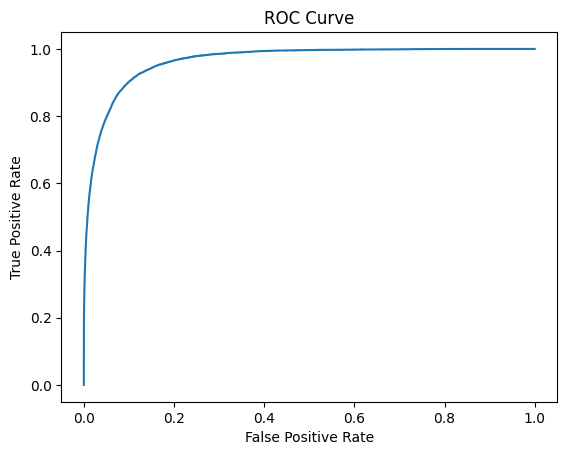

In [ ]:
import matplotlib.pyplot as plt
FPR, TPR, _= roc_curve(validate_labels, test_pred)
plt.plot(FPR, TPR)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')

## Conclusion:

### We achieved an accuracy of 95% on this model. This is very good even though the dataset is imbalanced. The 95% accuracy shows that we have built an effective classifier on a large dataset with an impressive ROC curve. In order to improve this model, we would need to improve the recall on the "True" class. We could do this by implementing a technique similar to SMOTE or ADASYN to upsample the minority class, which would likely be more effective than down sampling. We will look to improve this model in the future, for now I wanted to complete this type of project.

